## Categorization

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import spatial  
from sklearn.model_selection import LeaveOneOut

Data adapted from Leuven Concept Database (De Deyne et al., 2008).

Extract data from file.

In [2]:
df = pd.read_csv('data-categorization.csv')

Get feature list.

In [3]:
features = list(df.features)
features.remove('category')

Get names of all animals.

In [4]:
names = list(df); del names[0]

Get binary feature matrix (animal-by-feature).

In [5]:
F = pd.read_csv("data-categorization.csv", header=0, usecols=list(np.arange(1,54)))
F = np.asarray(F)

Get category labels.

In [6]:
labels = F[len(F)-1,:]

Config `F` such that each row is feature vector of one animal.

Each column is either a bird (category label = 0) or a fish (category label = 1).

In [7]:
F = np.delete(F,len(F)-1,0) 
F = np.transpose(F)

### Data visualization

Run the code below to visualize the animals in two dimensions, via multi-dimensional scaling.

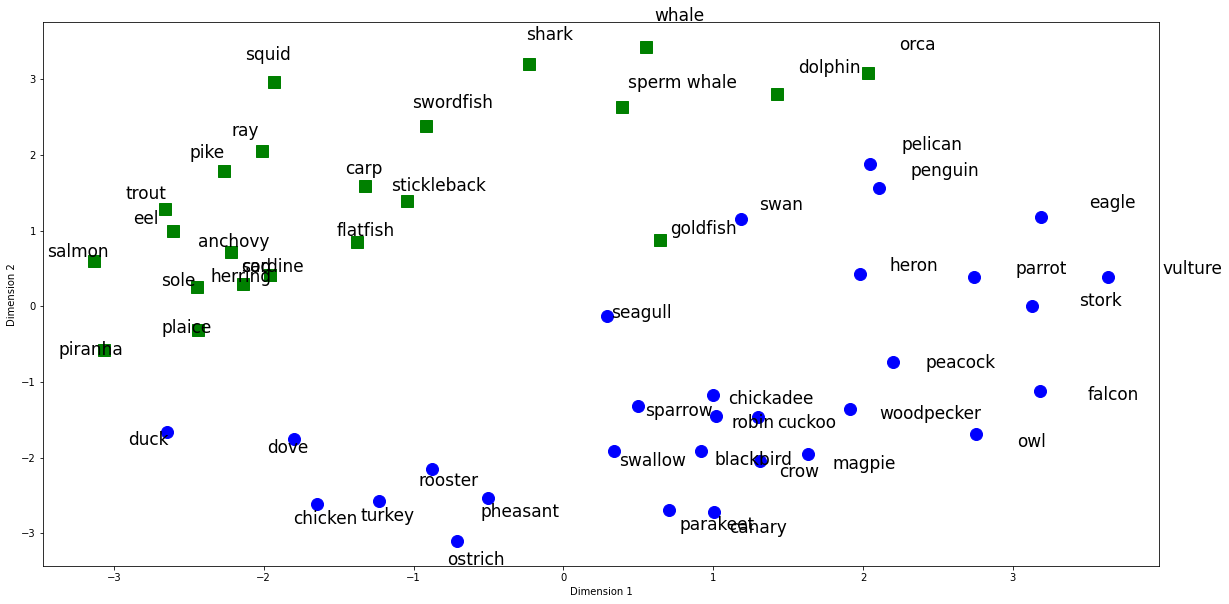

In [8]:
from sklearn.manifold import MDS

embedding = MDS(n_components=2)
F_lowdim = embedding.fit_transform(F)

birdinds = np.where(labels==0)
fishinds = np.where(labels==1)

fig = plt.figure(figsize=(20, 10))
plt.plot(F_lowdim[birdinds,0],F_lowdim[birdinds,1],'bo',markersize=12)
plt.plot(F_lowdim[fishinds,0],F_lowdim[fishinds,1],'gs',markersize=12)

for i in range(0,len(F)):
    plt.text(F_lowdim[i,0]*1.1,F_lowdim[i,1]*1.1,names[i],fontsize=17)
    
plt.xlabel('Dimension 1')    
plt.ylabel('Dimension 2')    

plt.show()

In [9]:
def predict_prototype(birds, fishes, test_data):
    # Build prototype: use bird and fish members to get category means
    bird = np.nanmean(birds, axis=0) # np.median(birds, axis=0) 
    fish = np.nanmean(fishes, axis=0) # np.median(fishes, axis=0)
    
    # Predict: compare Euclidean distance of the prototypes to the test_data. Select the smaller one as the category
    if spatial.distance.euclidean(bird, test_data) < spatial.distance.euclidean(fish, test_data):
#     if spatial.distance.cosine(bird, test_data) < spatial.distance.cosine(fish, test_data):
        return 0 # this is a bird
    else:
        return 1 # this is a fish

In [10]:
def similarity(members, test):
    sim = 0
    for member in members:
        sim += np.exp(-spatial.distance.euclidean(member, test)**2) # formula from class
    return sim/len(members)

In [11]:
def predict_exemplar(birds, fishes, test):
    # Predict: compare similarity of the category members to the test_data. Select the larger one as the category
    if similarity(birds, test) > similarity(fishes, test):
        return 0 # this is a bird
    else:
        return 1 # this is a fish

In [12]:
loo = LeaveOneOut()
loo.get_n_splits(F)

prototype_correct = 0
prototype_errors = []
exemplar_correct = 0
exemplar_errors = []

for train_index, test_index in loo.split(F):
    # train_index size is (# of animals -1) and test_index size is always 1
    
#     1) Get training and testing data points. 
    F_train, F_test = F[train_index], F[test_index]
    label_train, label_test = labels[train_index], labels[test_index]
    # Gather data: use training labels to select bird and fish indices
    birdinds = np.where(label_train==0)
    fishinds = np.where(label_train==1)
    # Build categories: use bird and fish indices to get category members
    birds = F_train[birdinds]
    fishes = F_train[fishinds]

#     2.1) Implement and predict with prototype model
    if predict_prototype(birds, fishes, F_test) == label_test:
        prototype_correct += 1
    else:
        prototype_errors.append(test_index[0]) # record the index of failiure

#     2.2) Implement and predict with exemplar model
    if predict_exemplar(birds, fishes, F_test) == label_test:
        exemplar_correct += 1
    else:
        exemplar_errors.append(test_index[0]) # record the index of failiure

# 3) Reporting predictive accuracies (%)
print("Prototype Accuracy: ", round(prototype_correct/labels.size*100, 2), "%")
print("Exemplar Accuracy: ", round(exemplar_correct/labels.size*100, 2), "%")

Prototype Accuracy:  94.34 %
Exemplar Accuracy:  96.23 %


In [15]:
# 4) Error analysis:

print("Prototype Failed on: ", [names[i] for i in prototype_errors])
print("\nExemplar Failed on: ", [names[i] for i in exemplar_errors]) 

# Details about the features the error animals have and don't have
features = np.asarray(features)
for i in set(prototype_errors + exemplar_errors):
    print('\n', names[i].capitalize(), "has: ", features[np.where(F[i]==1)[0]])
#     print("\n Does NOT have: ", features[np.where(F[i]==0)[0]])


Prototype Failed on:  ['duck', 'goldfish', 'orca']

Exemplar Failed on:  ['dolphin', 'goldfish']

 Goldfish has:  ['is a pet' 'can swim' 'is not eaten' 'is beautiful' 'is found in a pond'
 'can be bred' 'there are many kinds of it' 'is an animal' 'has a tail'
 'stinks' 'occurs frequently' 'can have different colors' 'lives in water'
 'is small' 'lays eggs' 'is sometimes kept as a pet' 'is not dangerous']

 Duck has:  ['has a big bill' 'is brown' 'makes a sound' 'is edible' 'can swim'
 'is beautiful' 'is found in a pond' 'can be bred' 'eats fish'
 'there are many kinds of it' 'is hunted' 'is eaten on festive dinners'
 'is an animal' 'has a tail' 'occurs frequently'
 'can have different colors' 'lives in water' 'is grey' 'herds' 'is small'
 'lays eggs' 'is tasty' 'dark colour' 'is not dangerous']

 Dolphin has:  ['is bluish grey' 'has a big bill' 'makes a sound' 'can swim' 'is big'
 'is not eaten' 'is beautiful' 'does not live in Belgium' 'eats fish'
 'there are many kinds of it' 'endang

**Considerations in model implementation:**

The accuracy of Prototype remains the same when the distance function is switched from Euclidean distance to Cosine similarity. The only thing that changes is that Orca is replaced with Dove. If the median of features is used as the prototype instead of means, then both Orca and Dove are errors and resulting in worse accuracy. So, the implementation with the best accuracy uses Euclidean distance and means.

For Exemplar, if the distance function is switched to Cosine, then the model does significantly worse, consisting of Dove, Duck, Seagull and Swan. So it performs best with the Euclidean distance.


**Errors with the data:**

When the features of each animal are examined in detail, it is easy to see that some are not relevant to its category membership or might be misleading. For example, in both Dolphins and Orcas we see "does not live in Belgium" or "stinks" as a feature. This does not give any information about its identity as a bird or a fish and so, increases the distance from similar animals, thus preventing proper categorization. Also, Orcas 'have a big bill' which is not only false, but artifically brings it closer to the bird category. More approproate features like "has wings", "has scales", "lives in oceans", etc might prevent such prediction errors from occuring.


**Model Comparisons using Errors:**

From the MDS plot, we note that Duck is closer to the fish cluster. Similarly, Orca and Dolphin are closer to the bird cluster. Goldfish is entirely within the bird cluster, and so can be considered an outlier. Therefore, most of the errors occur on perimeter cases, and so the differences in models come from their treatment of these cases.

In the Prototype model, we use the means of all category members to determine a prototype. But, the bird group distribution is more sparse, and the Prototype model doesn't account for variance, so members on the fringes like the Duck are likely to have a greater distance from the bird Prototype. This is why when changing the implementation of the Prototype model, the Dove may also be erroneously classified. While the fish category is less sparse, the Orca is at the perimeter and so has a greater distance from the prototype, therefore making it more likely to be categorized incorrectly.

The Exemplar model overcomes this by weighting the similarity values based on the distance, which is why we see a slight accuracy improvement. Excluding Goldfish since it is an outlier, the only error is Dolphin. From the MDS visualization, we can see that there are more bird members closer to it than fish members, thereby causing it to be incorrectly classified as a bird.